In [60]:
%load_ext autoreload
%autoreload 2
from Network import Network
from FrankWolf import *
from EntropyMaximisation import *
from RemoveBraess import *

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import seaborn.objects as so

import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning) 

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Identification of Braess links in traffic networks - Initial network calculations

This project aims to verify the hypothesis that Braess links could be identified with an adequate comparison of link flows at UE and at SO for a given OD.

In particular, we would like to verify whether links that, for a given OD, are used at UE (i.e. flow is significant) but not at SO (i.e. SO flow is not significant) are Braess links.

To start with, we need to compute the UE and SO flows for each OD pair. We will use the SiouxFalls network to test our hypothesis.

## Network creation

First, we create a `Network` instance that represent SiouxFalls network, using data from [the TransportationNetworks Github repo](https://github.com/bstabler/TransportationNetworks)

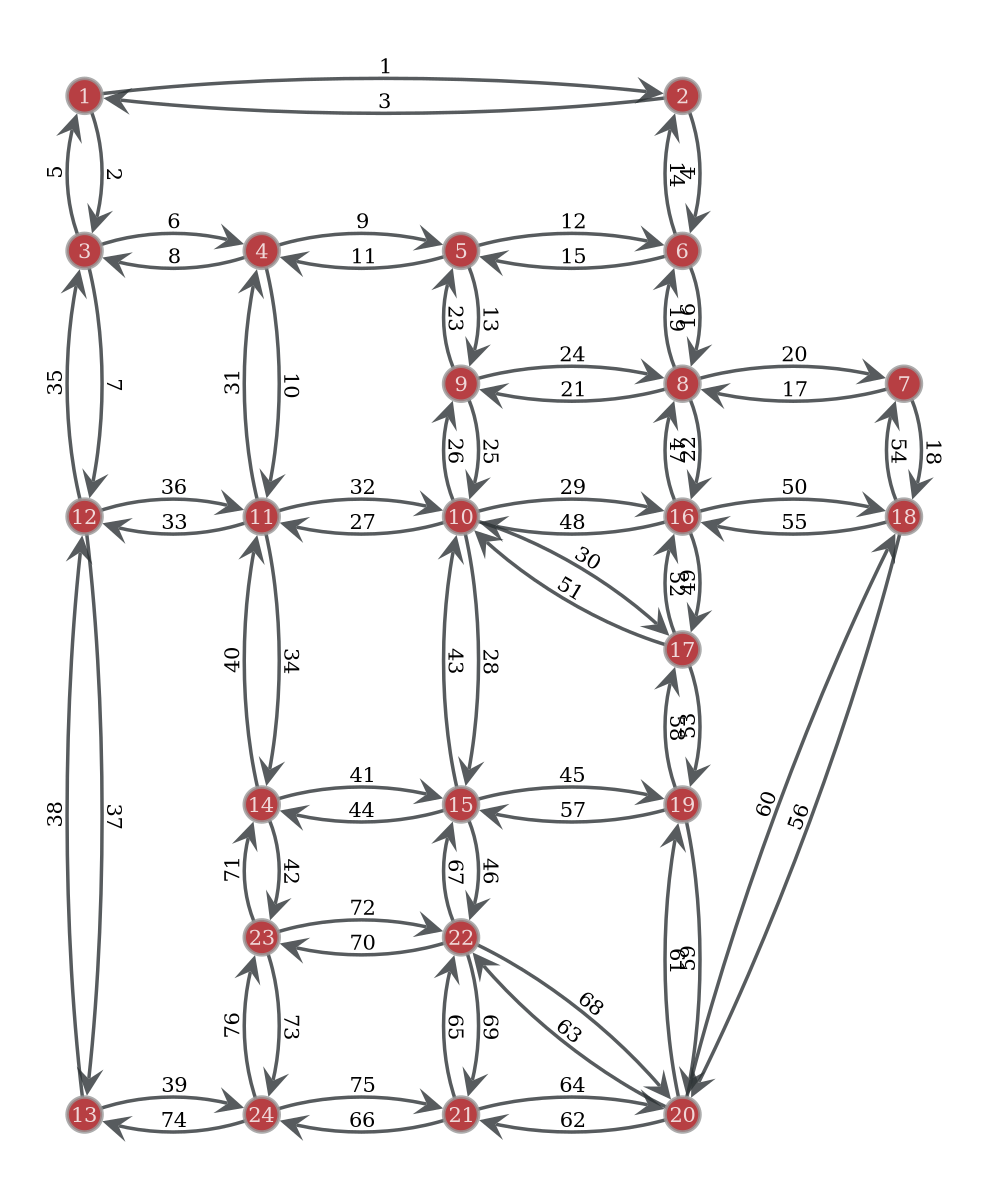

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x7f9198693410, at 0x7f919787a9c0>

In [61]:
net = Network("SiouxFalls")
net.draw()

## User Equilibrium (UE)

Now, we will compute UE flows this way :
1. Computing UE link flows using a frankwolf algorithm (These flows are unique)
2. Using Entropy Maximization through Alternative Representation of Bushes (EMARB) algorithm from Xie and Nie : A New Algorithm for Proportionality, we will equilibrate the path flows for every OD. This will give flows per origin
3. Get OD flows by reproducing the paths from the previous results

### A note on precision

Using our own Frank Wolf algorithm, and our own shortest path algorithm implementation, in python, we might not have the most optimised computation. As such, we might need to make a trade off between precision and performance.

Here, we will first run the FrankWolf algorithm with different precisions, and note the time it takes. We will then compare our results with the flows publicly availlable from the Transportation Networks github, and estimate our error from these flows.

In [62]:
import time

In [63]:
# Run the frankwolf algorith for different precisions and save the results
for i in range(2, 7, 1):
    print(f"Tolerance : 1e-{i}")
    start = time.time()
    frankwolf_by_origin, frankwolf_flows = frankwolf(net, net.trips, verbose=1, tolerance= 10**(-i), n_max=2e5)
    end = time.time()
    diff = end - start
    minutes = diff / 60
    print(f"Took {minutes:.2f} minutes")
    net.save_flow(frankwolf_by_origin, f"fw_p{i}", folder = os.path.join("files", "precision"))
    net.save_flow(frankwolf_flows, f"fw_p{i}", folder = os.path.join("files", "precision"))
    net.export_flow(frankwolf_by_origin, f"fw_p{i}", folder = os.path.join("exports", "precision"))
    net.export_flow(frankwolf_flows, f"fw_p{i}", folder = os.path.join("exports", "precision"))

# Save the results with the highest precision, for future use
net.save_flow(frankwolf_by_origin, "UE_FrankWolf_by_origin")
net.save_flow(frankwolf_flows, "UE_flows")
net.export_flow(frankwolf_by_origin, "UE_FrankWolf_by_origin")
net.export_flow(frankwolf_flows, "UE_flows")


"""
Performance :

1e-4 in ~1 min
1e-5 in ~10 min
1e-6 in ~1h30
1e-7 in > 3h
"""

Tolerance : 1e-2


26it [00:02, 11.47it/s, Relative error=9.68e-03]


Took 0.04 minutes
Tolerance : 1e-3


124it [00:09, 12.93it/s, Relative error=9.45e-04]


Took 0.16 minutes
Tolerance : 1e-4


1104it [01:25, 12.95it/s, Relative error=9.95e-05]


Took 1.42 minutes
Tolerance : 1e-5


9973it [12:59, 12.80it/s, Relative error=9.53e-06]


Took 12.99 minutes
Tolerance : 1e-6


95436it [2:13:36, 11.91it/s, Relative error=9.96e-07]


Took 133.60 minutes


'\nPerformance :\n\n1e-4 in ~1 min\n1e-5 in ~10 min\n1e-6 in ~1h30\n1e-7 in > 3h\n'

In [64]:
# Compare the results

### UE OD Flows

Now is time to apply Entropy Maximisation through Alternative Representation of bushes, from Xie and Nie.

In [65]:
frankwolf_by_origin = net.load_flow("UE_FrankWolf_by_origin")
flows_by_o = EMARB(net, frankwolf_by_origin, 1)
net.save_flow(flows_by_o, "UE_flows_by_o_EMARB")
net.export_flow(flows_by_o, "UE_flows_by_o_EMARB")

1: X.X.X.X.X.X.X.X.X.X.X.X.X.X.X.X.X.X.X.X.X.X.X.X: 100%|██████████| 24/24 [01:09<00:00,  2.88s/it]
2:  . .X.X.X.X. . . .X.X.X.X. .X.X.X. . .X. .X.X.X: 100%|██████████| 24/24 [00:44<00:00,  1.87s/it]
3:  . .X. . . . .X.X.X.X.X. . .X.X.X. .X.X. . .X.X: 100%|██████████| 24/24 [00:36<00:00,  1.53s/it]
4:  .X.X.X. . . .X. .X.X.X.X.X. .X.X. . . .X.X. . : 100%|██████████| 24/24 [00:40<00:00,  1.67s/it]
5:  . .X.X.X. .X.X. .X. .X. .X.X.X.X. . . .X. .X.X: 100%|██████████| 24/24 [01:11<00:00,  2.97s/it]
6:  . .X.X. .X. .X. .X. .X. . .X.X.X. . . .X. . . : 100%|██████████| 24/24 [00:29<00:00,  1.22s/it]
7:  . .X.X.X. . .X. .X. .X. . . .X.X. . . . . . .X: 100%|██████████| 24/24 [00:22<00:00,  1.06it/s]
8:  . .X.X. . . .X. .X. .X.X. .X.X.X. . . . . . . : 100%|██████████| 24/24 [00:21<00:00,  1.13it/s]
9:  . .X.X. .X. .X. .X.X.X. . .X.X.X. .X. .X.X. . : 100%|██████████| 24/24 [00:37<00:00,  1.56s/it]
10:  . .X.X.X.X.X.X. .X.X.X. . . .X.X. . . . . . . : 100%|██████████| 24/24 [01:04<00:00,  2.69s/it]

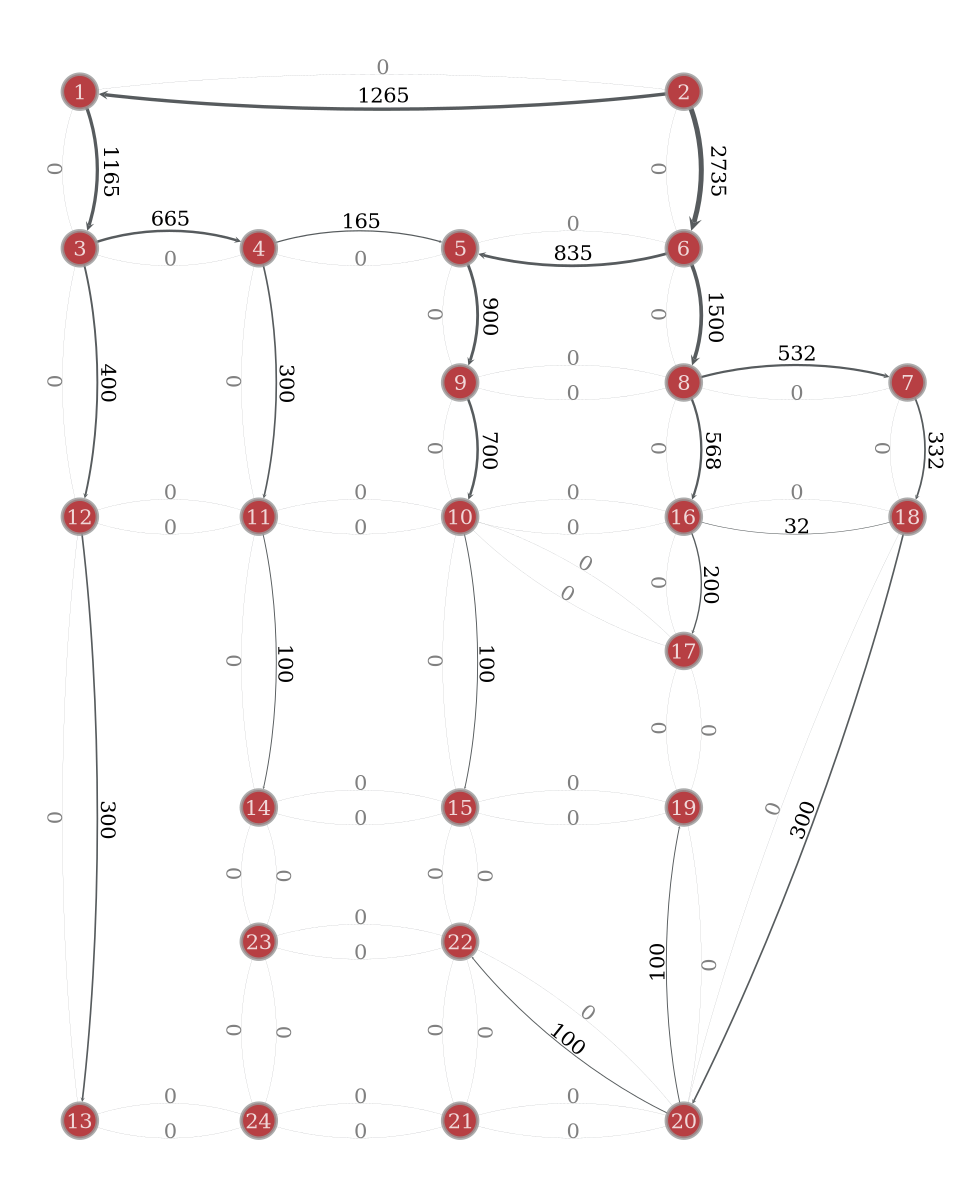

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x7f9198693410, at 0x7f919787a000>

In [66]:
#Visualisations
flows_by_o = net.load_flow("UE_flows_by_o_EMARB")

net.draw(flows_by_o = flows_by_o, o=1)

#### Threshold

We see that there are some values that are small, and those will later on have an impact on the number of paths generated, creating many paths with very small flow. As such, we will look at the distribution of the small values of those flows, to determine a threshold


<Axes: ylabel='Count'>

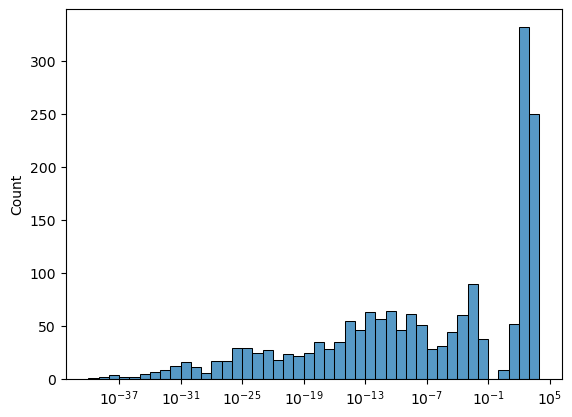

In [84]:
flows_by_o = net.load_flow("UE_flows_by_o_EMARB_p3")
flows_by_o_array = flows_by_o.get_2d_array()
sns.histplot(x=flows_by_o_array[(flows_by_o_array>0)], bins=np.arange(-40, 5, 1), log_scale=True)

As such, and for realisticness, we will apply a threshold of 0.1 to the flows. Indeed, compared with the order of magnitude of the individual OD demands (~ 1e2), we can consider this to be sufficiently small :

In [68]:
threshold = 1e-1
flows_by_o = net.load_flow("UE_flows_by_o_EMARB")
flows_by_o_array = flows_by_o.get_2d_array()
flows_by_o_filtered = flows_by_o.copy()
flows_by_o_array = np.where(flows_by_o_array > threshold, flows_by_o_array, 0)
flows_by_o_filtered.set_2d_array(flows_by_o_array)

net.save_flow(flows_by_o_filtered, "UE_flows_by_o_filtered")
net.export_flow(flows_by_o_filtered, "UE_flows_by_o_filtered")

<Axes: ylabel='Count'>

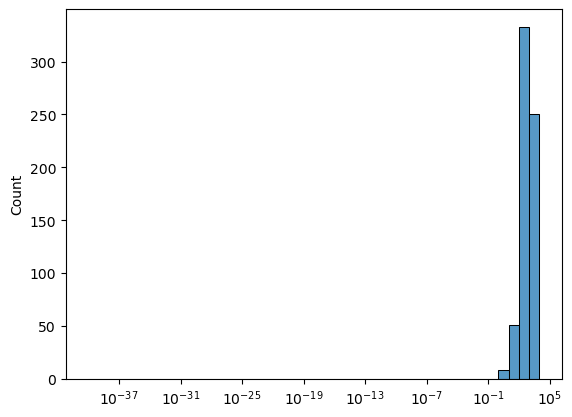

In [69]:
sns.histplot(x=flows_by_o_array[(flows_by_o_array>0)], bins=np.arange(-40, 5, 1), log_scale=True)

### UE paths and OD flows

Now, we can compute the UE paths and OD flows :

In [70]:
flows_by_o = net.load_flow("UE_flows_by_o_filtered")

OD_flows, paths = get_OD_flows(net, net.trips, flows_by_origin=flows_by_o, flow_limit = 1e-300, return_paths=True)
net.save_flow(OD_flows, "UE_OD_flows")
net.export_flow(OD_flows, "UE_OD_flows", OD_demand=net.trips)
_ = net.export_paths(paths, net.trips, name="UE_paths")

100%|██████████| 24/24 [02:09<00:00,  5.41s/it]


#### Threshold validity

We could validate our threshold, by looking at the distribution of the results. Indeed, we see that we do not have small values :

Text(0.5, 1.0, 'Distribution of the path flows, after applying a threshold of $0.1$')

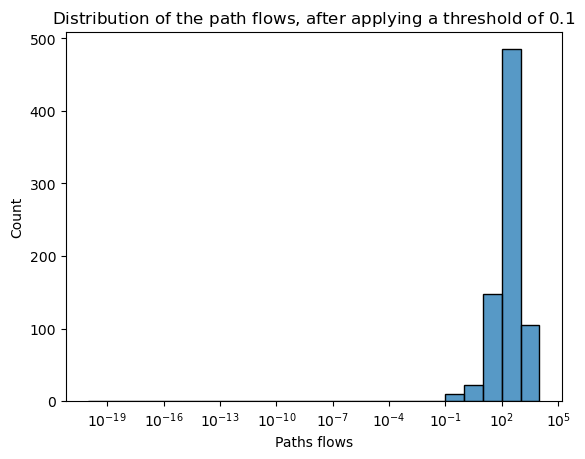

In [71]:
path_flows = np.array(sum([[f for _,f in p] for p in paths.values()], []))
sns.histplot(x=path_flows[(path_flows>0)], bins=np.arange(-20, 5, 1), log_scale=True)
plt.xlabel("Paths flows")
plt.title("Distribution of the path flows, after applying a threshold of $0.1$")

To compare, we can see what would have happened with a smaller threshold, for example $0.001$ :

100%|██████████| 24/24 [02:00<00:00,  5.01s/it]


Text(0.5, 1.0, 'Distribution of the path flows, after applying a threshold of $0.001$')

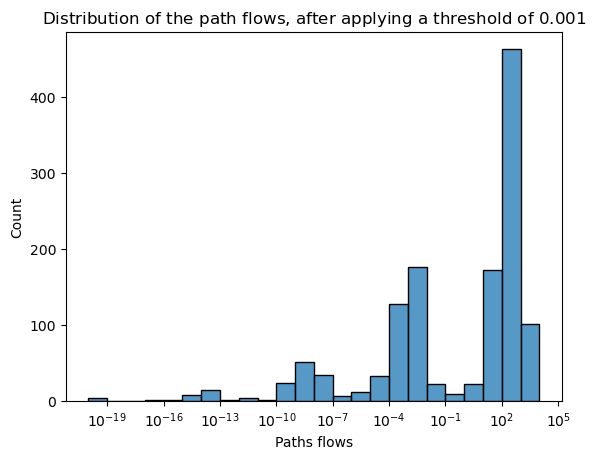

In [72]:
# Filtering 
flows_by_o = net.load_flow("UE_flows_by_o_EMARB")
flows_by_o_array = flows_by_o.get_2d_array()
flows_by_o_filtered = flows_by_o.copy()
flows_by_o_array = np.where(flows_by_o_array > 0.001, flows_by_o_array, 0)
flows_by_o_filtered.set_2d_array(flows_by_o_array)

# Compute the paths and their flows
OD_flows_comp, paths_comp = get_OD_flows(net, net.trips, flows_by_origin=flows_by_o_filtered, flow_limit = 1e-300, return_paths=True)

# Plot the histogram
path_flows_comp = np.array(sum([[f for _,f in p] for p in paths_comp.values()], []))
sns.histplot(x=path_flows_comp[(path_flows_comp>0)], bins=np.arange(-20, 5, 1), log_scale=True)
plt.xlabel("Paths flows")
plt.title("Distribution of the path flows, after applying a threshold of $0.001$")

#### Visualisation

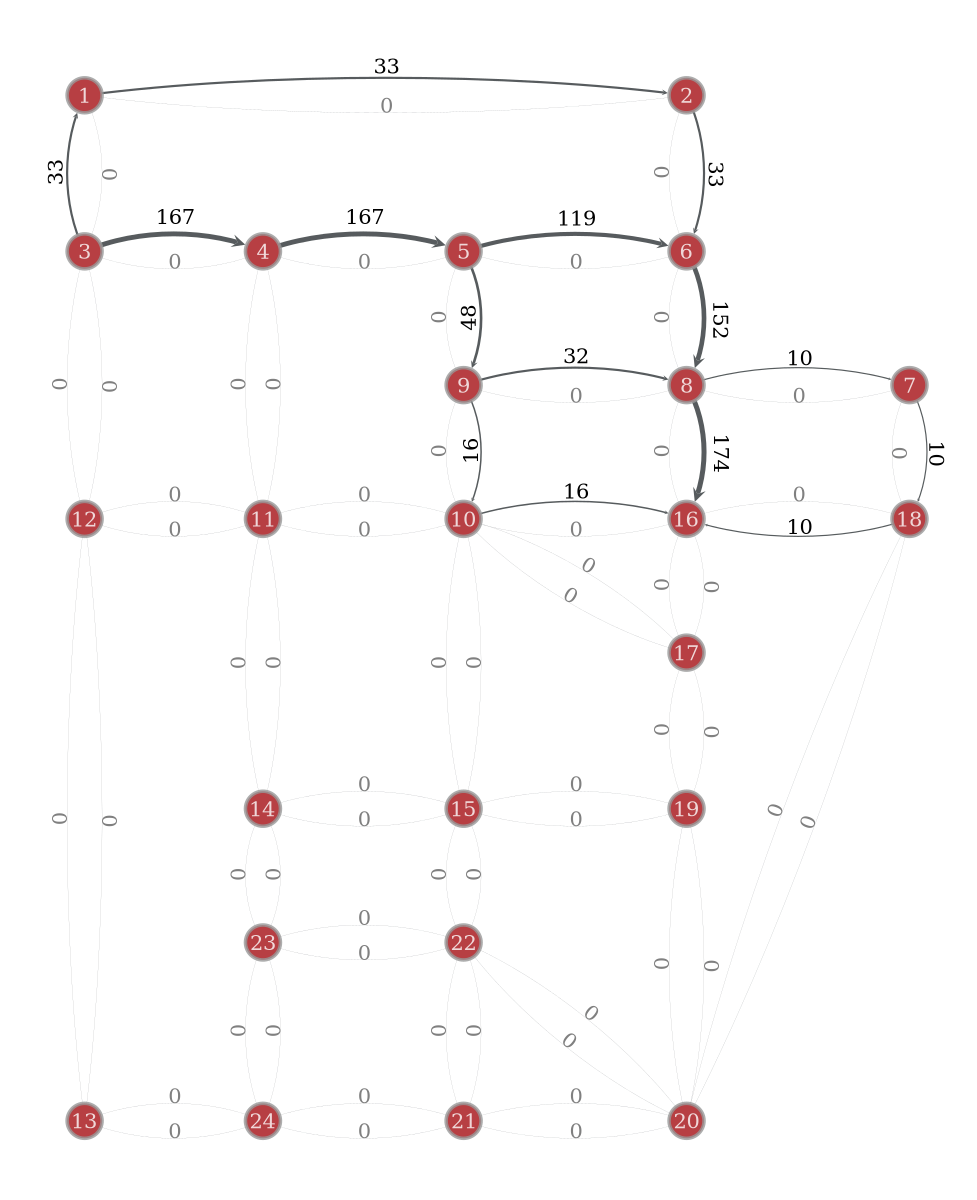

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x7f9198693410, at 0x7f9177924170>

In [73]:
# visualisations
OD_flows = net.load_flow("UE_OD_flows")
net.draw(flows_by_OD = OD_flows, o=2, d=15)

## System Optimum

Now, we reproduce the process for SO

In [74]:
# Frankwolf

# First with precision 1e-4
SO_fw_by_origin, SO_flows = frankwolf(net, net.trips, cost_function=BTR_marginal_cost_function, verbose=1, tolerance= 1e-4, n_max=2e5)
net.save_flow(SO_fw_by_origin, "SO_FrankWolf_by_origin_p4")
net.save_flow(SO_flows, "SO_flows_p4")
net.export_flow(SO_fw_by_origin, "SO_FrankWolf_by_origin_p4")
net.export_flow(SO_flows, "SO_flows_p4")


# Then with precision 1e-6
SO_fw_by_origin, SO_flows = frankwolf(net, net.trips, cost_function=BTR_marginal_cost_function, verbose=1, tolerance= 1e-6, n_max=2e5)
net.save_flow(SO_fw_by_origin, "SO_FrankWolf_by_origin")
net.save_flow(SO_flows, "SO_flows")
net.export_flow(SO_fw_by_origin, "SO_FrankWolf_by_origin")
net.export_flow(SO_flows, "SO_flows")


1974it [02:51, 11.49it/s, Relative error=9.64e-05]
180773it [4:07:22, 12.18it/s, Relative error=9.52e-07]


In [75]:
# EMARB
SO_fw_by_origin = net.load_flow("SO_FrankWolf_by_origin")
EMARB_SO_flows = EMARB(net, SO_fw_by_origin, 1)
net.save_flow(EMARB_SO_flows, "SO_flows_by_o_EMARB")
net.export_flow(EMARB_SO_flows, "SO_flows_by_o_EMARB")

1: X.X.X.X.X.X.X.X.X.X.X.X.X.X.X.X.X.X.X.X.X.X.X.X: 100%|██████████| 24/24 [01:16<00:00,  3.20s/it]
2:  . . . . . .X.X. .X. .X.X.X.X.X. . . .X. .X.X.X: 100%|██████████| 24/24 [00:29<00:00,  1.22s/it]
3: X. .X.X. .X. . . .X.X.X. .X.X.X. .X. .X. .X.X.X: 100%|██████████| 24/24 [00:45<00:00,  1.91s/it]
4: X. .X.X.X.X.X.X.X.X. .X.X.X.X. .X. .X. .X. .X.X: 100%|██████████| 24/24 [00:40<00:00,  1.70s/it]
5:  .X. . . . . . . .X.X.X.X.X.X.X. .X. .X.X.X.X.X: 100%|██████████| 24/24 [00:53<00:00,  2.21s/it]
6: X. .X.X. . . . . .X. .X.X.X.X.X. .X. .X.X.X.X.X: 100%|██████████| 24/24 [00:33<00:00,  1.41s/it]
7:  .X. . . . .X.X. .X.X.X.X.X.X.X. .X. .X.X. .X.X: 100%|██████████| 24/24 [00:33<00:00,  1.39s/it]
7it [05:12, 44.68s/it]


<Axes: ylabel='Count'>

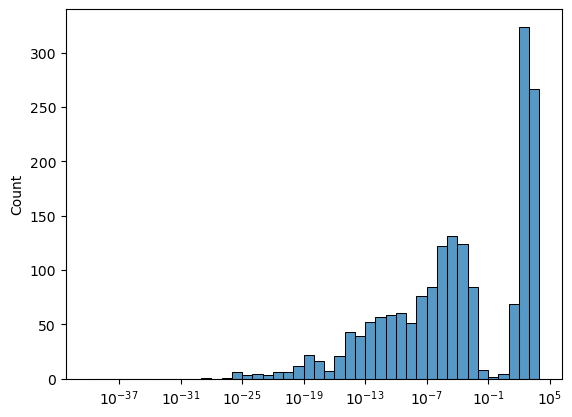

In [76]:
# Threshold
flows_by_o = net.load_flow("SO_flows_by_o_EMARB")
flows_by_o_array = flows_by_o.get_2d_array()
sns.histplot(x=flows_by_o_array[(flows_by_o_array>0)], bins=np.arange(-40, 5, 1), log_scale=True)

In [77]:
# Applying threshold
flows_by_o = net.load_flow("SO_flows_by_o_EMARB")
flows_by_o_array = flows_by_o.get_2d_array()
flows_by_o_filtered = flows_by_o.copy()
flows_by_o_array = np.where(flows_by_o_array > threshold, flows_by_o_array, 0)
flows_by_o_filtered.set_2d_array(flows_by_o_array)

net.save_flow(flows_by_o_filtered, "SO_flows_by_o_filtered")
net.export_flow(flows_by_o_filtered, "SO_flows_by_o_filtered")

In [78]:
# Paths, OD_flows
 
EMARB_SO_flows = net.load_flow("SO_flows_by_o_filtered")

SO_OD_flows, paths = get_OD_flows(net, net.trips, flows_by_origin=EMARB_SO_flows, flow_limit=1e-300, return_paths=True)

net.save_flow(SO_OD_flows, "SO_OD_flows")
net.export_flow(SO_OD_flows, "SO_OD_flows", OD_demand=net.trips)
net.export_paths(paths, net.trips, name="SO_paths")

100%|██████████| 24/24 [01:26<00:00,  3.61s/it]


'  2 ->   1 (100.0):\n\t     100 : [1, 2]\n\n  3 ->   1 (100.0):\n\t     100 : [1, 3]\n\n  4 ->   1 (500.0):\n\t     500 : [1, 3, 4]\n\n  5 ->   1 (200.0):\n\t     200 : [1, 3, 4, 5]\n\n  6 ->   1 (300.0):\n\t     300 : [1, 2, 6]\n\n  7 ->   1 (500.0):\n\t     500 : [1, 2, 6, 8, 7]\n\n  8 ->   1 (800.0):\n\t     800 : [1, 2, 6, 8]\n\n  9 ->   1 (500.0):\n\t     500 : [1, 3, 4, 5, 9]\n\n 10 ->   1 (1300.0):\n\t1.23e+03 : [1, 3, 4, 5, 9, 10]\n\t    69.7 : [1, 3, 4, 11, 10]\n\n 11 ->   1 (500.0):\n\t     500 : [1, 3, 4, 11]\n\n 12 ->   1 (200.0):\n\t     200 : [1, 3, 12]\n\n 13 ->   1 (500.0):\n\t     500 : [1, 3, 12, 13]\n\n 14 ->   1 (300.0):\n\t     300 : [1, 3, 4, 11, 14]\n\n 15 ->   1 (500.0):\n\t     473 : [1, 3, 4, 5, 9, 10, 15]\n\t    26.8 : [1, 3, 4, 11, 10, 15]\n\n 16 ->   1 (500.0):\n\t     153 : [1, 2, 6, 8, 7, 18, 16]\n\t     347 : [1, 2, 6, 8, 16]\n\n 17 ->   1 (400.0):\n\t    26.6 : [1, 3, 4, 5, 9, 10, 15, 19, 17]\n\t     352 : [1, 3, 4, 5, 9, 10, 17]\n\t    1.51 : [1, 3, 4

Text(0.5, 0.98, 'System Optimum')

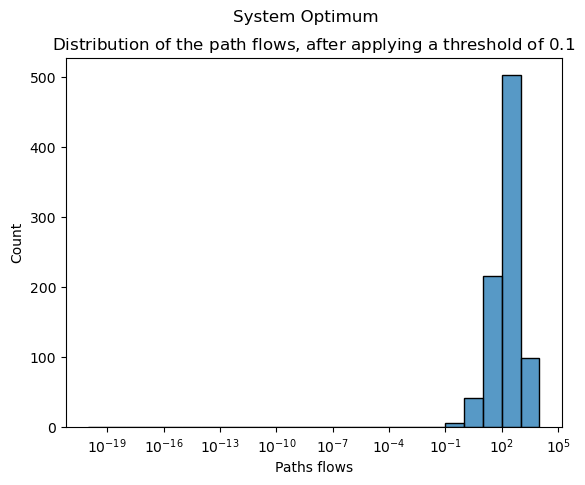

In [79]:
# Threshold validation 1
path_flows = np.array(sum([[f for _,f in p] for p in paths.values()], []))
sns.histplot(x=path_flows[(path_flows>0)], bins=np.arange(-20, 5, 1), log_scale=True)
plt.xlabel("Paths flows")
plt.title("Distribution of the path flows, after applying a threshold of $0.1$")
plt.suptitle("System Optimum")

Text(0.5, 0.98, 'System Optimum')

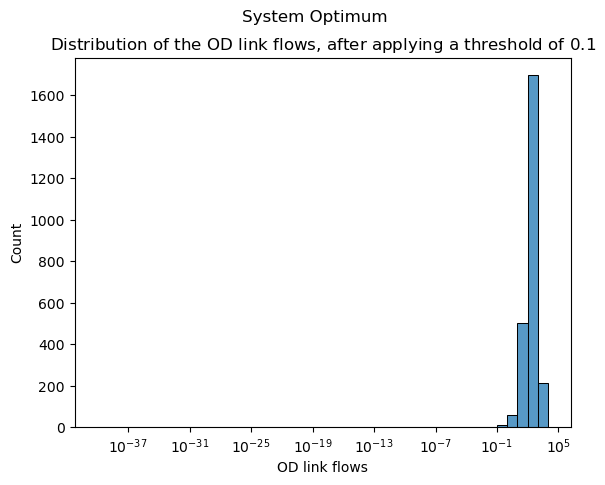

In [80]:
# Threshold validation 2
SO_OD_flows = net.load_flow("SO_OD_flows")
sns.histplot(x=SO_OD_flows[(SO_OD_flows>0)], bins=np.arange(-40, 5, 1), log_scale=True)
plt.xlabel("OD link flows")
plt.title("Distribution of the OD link flows, after applying a threshold of $0.1$")
plt.suptitle("System Optimum")

## Try at better EMARB precision

In [81]:
p=1
epsilon = 10**(-p)

# UE
frankwolf_by_origin = net.load_flow("UE_FrankWolf_by_origin")
flows_by_o = EMARB(net, frankwolf_by_origin, epsilon=epsilon)
net.save_flow(flows_by_o, f"UE_flows_by_o_EMARB_p{p}")
net.export_flow(flows_by_o, f"UE_flows_by_o_EMARB_p{p}")

# SO
frankwolf_by_origin = net.load_flow("SO_FrankWolf_by_origin")
flows_by_o = EMARB(net, frankwolf_by_origin, epsilon=epsilon)
net.save_flow(flows_by_o, f"SO_flows_by_o_EMARB_p{p}")
net.export_flow(flows_by_o, f"SO_flows_by_o_EMARB_p{p}")

1: X.X.X.X.X.X.X.X.X.X.X.X.X.X.X.X.X.X.X.X.X.X.X.X: 100%|██████████| 24/24 [00:49<00:00,  2.05s/it]
2:  . .X.X.X.X. . . .X.X.X.X. .X.X.X. . .X. .X.X.X: 100%|██████████| 24/24 [00:31<00:00,  1.29s/it]
3:  . .X. . . . .X.X.X.X.X. . .X.X.X. .X.X. . .X.X: 100%|██████████| 24/24 [00:25<00:00,  1.07s/it]
4:  .X.X.X. . . .X. .X.X.X.X.X. .X.X. . . .X.X. . : 100%|██████████| 24/24 [00:24<00:00,  1.02s/it]
5:  . .X.X.X. .X.X. .X. .X. .X.X.X.X. . . .X. .X.X: 100%|██████████| 24/24 [00:46<00:00,  1.93s/it]
6:  . .X.X. .X. .X. .X. .X. . .X.X.X. . . .X. . . : 100%|██████████| 24/24 [00:17<00:00,  1.37it/s]
7:  . .X.X.X. . .X. .X. .X. . . .X.X. . . . . . .X: 100%|██████████| 24/24 [00:17<00:00,  1.37it/s]
8:  . .X.X. . . .X. .X. .X.X. .X.X.X. . . . . . . : 100%|██████████| 24/24 [00:17<00:00,  1.35it/s]
9:  . .X.X. .X. .X. .X.X.X. . .X.X.X. .X. .X.X. . : 100%|██████████| 24/24 [00:21<00:00,  1.13it/s]
10:  . .X.X.X.X.X.X. .X.X.X. . . .X.X. . . . . . . : 100%|██████████| 24/24 [00:43<00:00,  1.82s/it]

In [82]:
p=2
epsilon = 10**(-p)

# UE
frankwolf_by_origin = net.load_flow("UE_FrankWolf_by_origin")
flows_by_o = EMARB(net, frankwolf_by_origin, epsilon=epsilon)
net.save_flow(flows_by_o, f"UE_flows_by_o_EMARB_p{p}")
net.export_flow(flows_by_o, f"UE_flows_by_o_EMARB_p{p}")

# SO
frankwolf_by_origin = net.load_flow("SO_FrankWolf_by_origin")
flows_by_o = EMARB(net, frankwolf_by_origin, epsilon=epsilon)
net.save_flow(flows_by_o, f"SO_flows_by_o_EMARB_p{p}")
net.export_flow(flows_by_o, f"SO_flows_by_o_EMARB_p{p}")

1: X.X.X.X.X.X.X.X.X.X.X.X.X.X.X.X.X.X.X.X.X.X.X.X: 100%|██████████| 24/24 [00:51<00:00,  2.14s/it]
2:  . .X.X.X.X. . . .X.X.X.X. .X.X.X. . .X. .X.X.X: 100%|██████████| 24/24 [00:29<00:00,  1.25s/it]
3:  . .X. . . . .X.X.X.X.X. . .X.X.X. .X.X. . .X.X: 100%|██████████| 24/24 [00:26<00:00,  1.09s/it]
4:  .X.X.X. . . .X. .X.X.X.X.X. .X.X. . . .X.X. . : 100%|██████████| 24/24 [00:27<00:00,  1.14s/it]
5:  . .X.X.X. .X.X. .X. .X. .X.X.X.X. . . .X. .X.X: 100%|██████████| 24/24 [00:42<00:00,  1.77s/it]
6:  . .X.X. .X. .X. .X. .X. . .X.X.X. . . .X. . . : 100%|██████████| 24/24 [00:21<00:00,  1.13it/s]
7:  . .X.X.X. . .X. .X. .X. . . .X.X. . . . . . .X: 100%|██████████| 24/24 [00:16<00:00,  1.44it/s]
8:  . .X.X. . . .X. .X. .X.X. .X.X.X. . . . . . . : 100%|██████████| 24/24 [00:16<00:00,  1.42it/s]
9:  . .X.X. .X. .X. .X.X.X. . .X.X.X. .X. .X.X. . : 100%|██████████| 24/24 [00:25<00:00,  1.08s/it]
10:  . .X.X.X.X.X.X. .X.X.X. . . .X.X. . . . . . . : 100%|██████████| 24/24 [00:40<00:00,  1.68s/it]

In [83]:
p=3
epsilon = 10**(-p)

# UE
frankwolf_by_origin = net.load_flow("UE_FrankWolf_by_origin")
flows_by_o = EMARB(net, frankwolf_by_origin, epsilon=epsilon)
net.save_flow(flows_by_o, f"UE_flows_by_o_EMARB_p{p}")
net.export_flow(flows_by_o, f"UE_flows_by_o_EMARB_p{p}")

# SO
frankwolf_by_origin = net.load_flow("SO_FrankWolf_by_origin")
flows_by_o = EMARB(net, frankwolf_by_origin, epsilon=epsilon)
net.save_flow(flows_by_o, f"SO_flows_by_o_EMARB_p{p}")
net.export_flow(flows_by_o, f"SO_flows_by_o_EMARB_p{p}")

1: X.X.X.X.X.X.X.X.X.X.X.X.X.X.X.X.X.X.X.X.X.X.X.X: 100%|██████████| 24/24 [00:50<00:00,  2.11s/it]
2:  . .X.X.X.X. . . .X.X.X.X. .X.X.X. . .X. .X.X.X: 100%|██████████| 24/24 [00:28<00:00,  1.20s/it]
3:  . .X. . . . .X.X.X.X.X. . .X.X.X. .X.X. . .X.X: 100%|██████████| 24/24 [00:30<00:00,  1.29s/it]
4:  .X.X.X. . . .X. .X.X.X.X.X. .X.X. . . .X.X. . : 100%|██████████| 24/24 [00:22<00:00,  1.05it/s]
5:  . .X.X.X. .X.X. .X. .X. .X.X.X.X. . . .X. .X.X: 100%|██████████| 24/24 [00:45<00:00,  1.89s/it]
6:  . .X.X. .X. .X. .X. .X. . .X.X.X. . . .X. . . : 100%|██████████| 24/24 [00:16<00:00,  1.43it/s]
7:  . .X.X.X. . .X. .X. .X. . . .X.X. . . . . . .X: 100%|██████████| 24/24 [00:13<00:00,  1.75it/s]
8:  . .X.X. . . .X. .X. .X.X. .X.X.X. . . . . . . : 100%|██████████| 24/24 [00:17<00:00,  1.37it/s]
9:  . .X.X. .X. .X. .X.X.X. . .X.X.X. .X. .X.X. . : 100%|██████████| 24/24 [00:23<00:00,  1.04it/s]
10:  . .X.X.X.X.X.X. .X.X.X. . . .X.X. . . . . . . : 100%|██████████| 24/24 [00:44<00:00,  1.85s/it]